# Classification using 'video list'

In [5]:
#default_exp nb_04b

In [6]:
#export
import cv2
from fastai.core import *
from fastai.vision import *
from facenet_pytorch import MTCNN
from kgl_deepfake.nb_00 import *
from kgl_deepfake.nb_01b import *
from kgl_deepfake.nb_03 import *

### Data

In [7]:
SOURCE = Path('../data/train_sample_videos/')

In [8]:
f = get_files(SOURCE, extensions=['.json'])[0]
annots = pd.read_json(f).T
annots.reset_index(inplace=True)
annots.rename({'index':'fname'}, axis=1, inplace=True)
annots.head()

,fname,label,split,original
0,aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
1,aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
2,abarnvbtwb.mp4,REAL,train,None
3,abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
4,abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


#### Get face detector

In [9]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [10]:
detector = MTCNN(device=device, post_process=False)

#### Remove videos in which no faces are detected.  

In [11]:
fnames = [SOURCE/o for o in annots.fname]

In [13]:
hasface = get_has_face(fnames, detector)

In [14]:
annots_hasface = annots[np.array(hasface)]

#### Create `DataBunch`

In [15]:
src = (VideoFaceList
       .from_df(df=annots_hasface, path=SOURCE, cols='fname', detector=detector)
       .split_by_rand_pct())

In [16]:
bs, sz = 32, 128

In [17]:
%%time
data = (src.label_from_df('label').transform(get_transforms(), size=sz)
        .databunch(bs=bs, num_workers=0).normalize(imagenet_stats))

CPU times: user 20.2 s, sys: 246 ms, total: 20.5 s
Wall time: 3.99 s


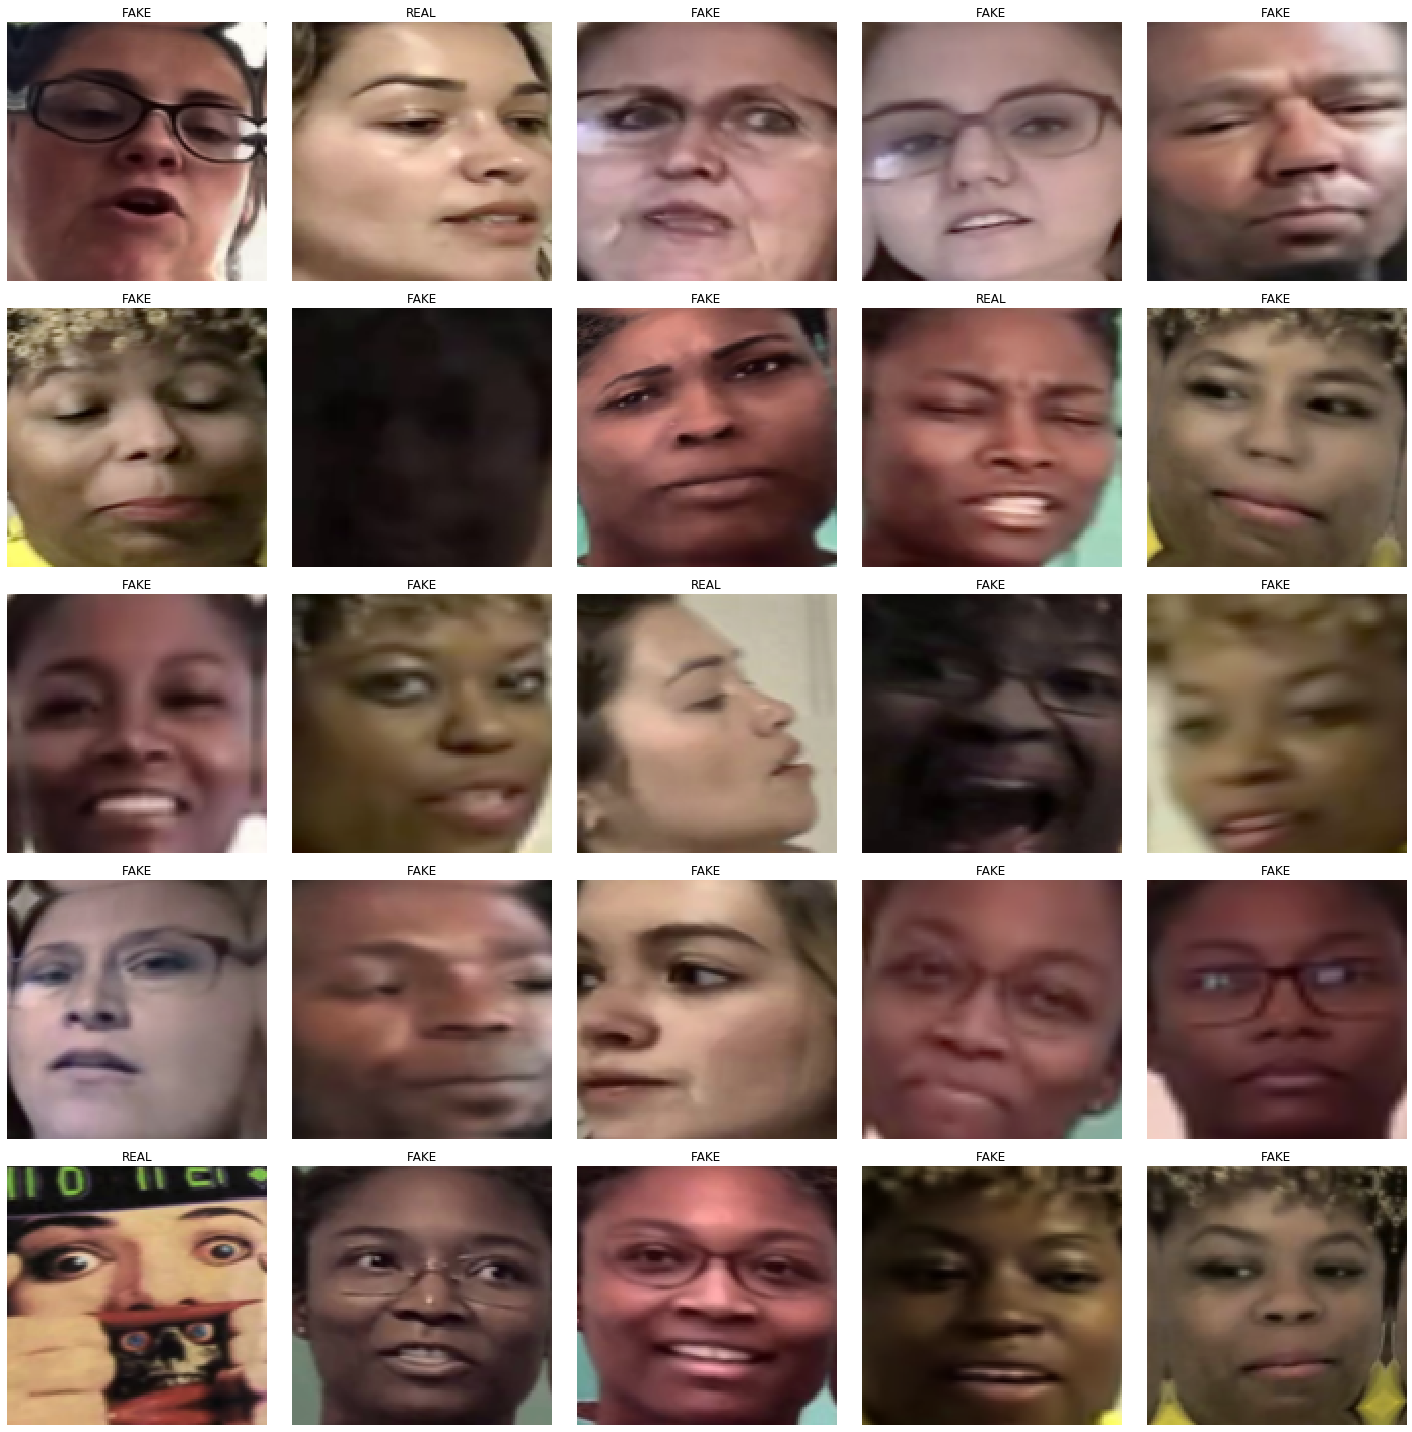

In [18]:
data.show_batch()

### Model

In [19]:
net = models.resnet18

### Learner

In [20]:
learn = cnn_learner(data, net, metrics=accuracy)

### Train

In [21]:
from fastai.callbacks.oversampling import OverSamplingCallback

cb = OverSamplingCallback(learn)

In [22]:
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, callbacks=[cb])

epoch,train_loss,valid_loss,accuracy,time
0,1.198096,0.939920,0.612500,01:12


### Inference

In [23]:
SOURCE_TEST = Path('../data/test_videos/')

In [24]:
fnames = get_files(SOURCE_TEST, extensions=['.mp4'])
fnames[:3]

[PosixPath('../data/test_videos/apedduehoy.mp4'),
 PosixPath('../data/test_videos/ajiyrjfyzp.mp4'),
 PosixPath('../data/test_videos/aqrsylrzgi.mp4')]

In [25]:
class DetectionPipeline: 
    def __init__(self, detector=None, nf=None, bs=60, fsz=None):
        if detector is None: detector = self.default_detector()
        self.detector = detector
        self.nf, self.bs, self.fsz = nf, bs, fsz
    
    def default_detector(self):
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        return MTCNN(device=device, image_size=256,
                     post_process=False, select_largest=False, keep_all=True)
        
    def get_sample(self, vlen, n_frames):
        if n_frames is None: return np.arange(0, vlen)
        else: return np.linspace(0, vlen - 1, n_frames).astype(int)
    
    def resize(self, frame, size):
        return frame.resize([int(d * size) for d in frame.size])
    
    def get_savepaths(self, filename, idxs, label=None, save_dir=None):
        if isinstance(filename, str): filename = Path(filename)
        if save_dir is None: save_dir = Path('./')
        if label is None: save_paths = [save_dir/f'{filename.stem}_{i:03d}.png' for i in idxs]
        else: save_paths = [save_dir/f'{filename.stem}_{i:03d}_{label}.png' for i in idxs]
        return [str(o) for o in save_paths]  
            
    def equalize(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        frame[:,:,0] = clahe.apply(frame[:,:,0])
        return cv2.cvtColor(frame, cv2.COLOR_YCrCb2RGB)
    
    def __call__(self, filename, equalize=False, label=None, save_dir=None):
        assert Path(filename).exists()
        vcap = cv2.VideoCapture(str(filename))
        vlen = int(vcap.get(cv2.CAP_PROP_FRAME_COUNT))
        sample = self.get_sample(vlen, self.nf)
        iframes, faces, probs = [], [], []
        ib, fb = [], []
        for i in range(vlen):
            _ = vcap.grab()
            if i in sample:
                success, f = vcap.retrieve()
                if not success: continue
                if equalize: f = self.equalize(f)
                else: f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
                f = PIL.Image.fromarray(f)
                if self.fsz is not None: f = self.resize(f, self.fsz)
                ib.append(i); fb.append(f)
                if len(fb) % self.bs == 0 or i == sample[-1]:
                    savepaths = self.get_savepaths(filename, ib, label, save_dir) if save_dir else None
                    faceb, probb = self.detector(fb, return_prob=True, save_path=savepaths)
                    iframes.extend(ib); faces.extend(faceb); probs.extend(probb)
                    ib, fb = [], []
        vcap.release()
        return iframes, faces, probs

In [26]:
#export
def inference(learn:Learner, path:Path, nf=15, equalize=False):
    
    filenames, labels = [], []
    
    facepipe = DetectionPipeline(nf=nf)
    
    for fn in progress_bar(path.ls()):
        if fn.suffix == '.mp4':
            try:
                preds = []
                iframes, faces, probs = facepipe(fn, equalize=equalize)

                for face in faces:
                    if face is not None and face.shape[0]==1: # Only do the inference if there is a face detected
                        _,_,pred = learn.predict(Image((face/255.).squeeze()))
                        preds.append(pred[0])
                    else: preds.append(0.5) # if #face <1 or >1 in a frame, predict 0.5

                mean_pred = np.mean(preds)

            except Exception:
                print(f'except: {fn}')
                mean_pred = 0.5

            filenames.append(fn.name)
            labels.append(mean_pred)          
    return pd.DataFrame({'filename':filenames, 'label':labels})

In [ ]:
df = inference(learn, SOURCE_TEST)

In [ ]:
df.head()

# - fin

In [126]:
from nbdev.export import *
notebook2script()

Converted 00_lookatdata.ipynb.
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
Converted 01_face_recog.ipynb.
Converted 01a_face_extraction.ipynb.
Converted 01b_get_one_face.ipynb.
Converted 02a_create_faceimage_dataset.ipynb.
Converted 02bis_Create_Dataset-Copy1.ipynb.
Converted 02bis_Create_Dataset.ipynb.
Converted 03_mesonet.ipynb.
Converted 04_Baseline_Classification-Copy1.ipynb.
Converted 04_Baseline_Classification.ipynb.
Converted 04_Classification.ipynb.
Converted 04a_classification_videolist.ipynb.
Converted 05_Class_Imbalance.ipynb.
Converted 06_Focal_Loss.ipynb.
Converted test_submission.ipynb.
